# INF4480 Spring of 2021 - Project 3
### By Olav Fønstelien 2021-0x-xx
<br>

### Notes:
* Implementation in Python using NumPy, SciPy, matplotlib
* Generating slides from Jupyter Lab, and including most of the code since I myself think it is always interesting to see how things were done, and would also like feedback as well as tips and tricks
* The slides are in reveal.js format. Navigate by going right/left for Assignments 1-2-3 etc., and up/down for sub-assignments 1A-1B-1C etc.

## Introduction

We begin by setting up the environment...

In [1]:
### Setting up environment
import numpy as np
from scipy.io import loadmat
from scipy.signal import correlate, resample
from scipy.fft import fft
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In this assignment we analyse the signal received by a sonar after one single ping. The sonar is an array of 32 hydrophones arranged horizontally. The ping is reflected by a fish swimming in the water some meters away, and we will look at two different ways of estimating the distance; first by the Maximum Likelihood Estimator (MLE) and then by the Linear Least Squares Estimator (LSE). We will also calculate the Cramér-Rao Lower Bound on the variance of an estimator for the received signal.

The sonar recording is stored in a file ```sonardata.mat```. Let's first read this and look at it's content:

In [2]:
sonardata = loadmat('sonardata4.mat')
print('keys =', sonardata.keys())

keys = dict_keys(['__header__', '__version__', '__globals__', 'data', 'B', 'fs', 'fc', 'T_p'])


* ```data``` is the recorded (reflected) signal
* ```fs``` is the sampling rate
* ```t_0``` is the start of recording after (time offset)
* ```T_p``` is the pulse length
* ```B``` is the sonar signal's bandwith
* ```c``` is the sound of speed in water
* ```fc``` is the sonar signal's center frequency

Let's look a little closer on the ```data```. 

First, we see that it has 10,000 samples on 32 channels, and that the signal is complex.

In [3]:
sonardata['data'].shape, sonardata['data'][:5,0]

((10000, 32),
 array([ 3.0517578e-05+3.0517578e-05j, -3.0517578e-05-3.0517578e-05j,
         3.0517578e-05+3.0517578e-05j, -3.0517578e-05-3.0517578e-05j,
         3.0517578e-05+3.0517578e-05j], dtype=complex64))

In the assignment we will use only the first 1600, so let's look at the signal on one of the channels, say channel 12.

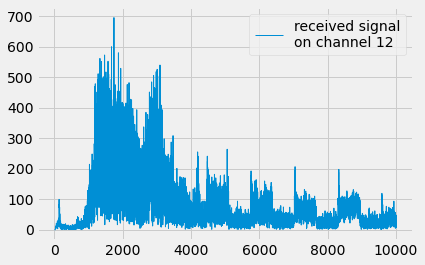

In [4]:
plt.plot(np.abs(sonardata['data'][:, 12]), lw=1, label='received signal\non channel 12')
plt.legend()

We see that there is something happening somewhere between 250 and 500, which corresponds to somewhere between approximately 13 and 18 meters. 

In the following we will see if we can determine the distance with higher confidence by _matched filtering_ and the MLE and LSE methods, but let's first allocate some variables:

In [5]:
# Allocating variables
fs = float(sonardata['fs'])
Tp = float(sonardata['T_p'])
B = float(sonardata['B'])
fc = float(sonardata['fc'])
X = sonardata['data']
Nt, Nh = X.shape
print(f'fs={fs}, Tp={Tp}, B={B}, fc={fc}')

fs=40000.0, Tp=0.003499, B=30000.0, fc=100000.0


... and have a look at the ping signal pulse, which is given by the equation
$$
s(t) =  \bigg\{
    \begin{aligned}
    &\mathrm{exp}(j2 \pi \alpha t^2 / 2) \quad &&-T_p / 2 \le t \le T_p / 2\\
    &0 &&\text{otherwise}
    \end{aligned}
$$
where $\alpha = B/T_p$.

In [6]:
# Ping signal
Ns = int(Tp*fs)
alpha = B/Tp
ts = np.linspace(-Tp/2, Tp/2, Ns)
s = np.exp(1j*np.pi*alpha*ts**2)

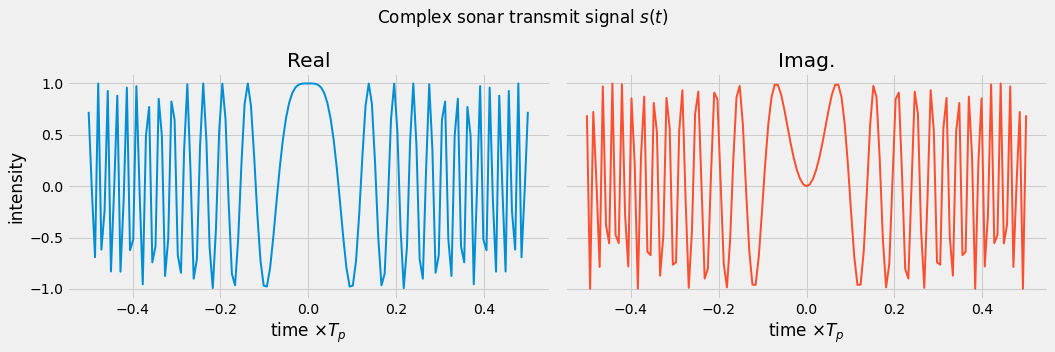

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Complex sonar transmit signal $s(t)$')

ax = axes[0]
ax.set_title('Real')
ax.plot(ts/Tp, np.real(np.exp(1j*np.pi*alpha*ts**2)), lw=2)
ax.set_xlabel(r'time $\times T_p$')
ax.set_ylabel(r'intensity')

ax = axes[1]
ax.set_title('Imag.')
ax.plot(ts/Tp, np.imag(np.exp(1j*np.pi*alpha*ts**2)), lw=2, color=COLORS[1])
ax.set_xlabel(r'time $\times T_p$')

plt.tight_layout()
plt.show()

In [8]:
def matched_filtering(X, s):
    '''Performs matched filtering of X by s. X is the received signal of an array ordered by (channel, signal).'''
    xc = np.empty(X.shape, dtype=np.complex)
    for i, x in enumerate(X.T):
        xc[:,i] = correlate(x, s, mode='same')
    return xc

In [9]:
Xs = matched_filtering(X, s)

## Assignment 1 - xxx

### Ex. 1A - XXX

In [10]:
def window(N, n0=0, wN=None, wname='rectangular'):
    '''Returns a window sequence starting at n0, with window length N, and zero padding up to wN; Choose wname={'rectangular', 'hamming', 'hanning'}.'''
    assert wname in ['rectangular', 'hamming', 'hanning']
    if not wN:
        wN = N + n0

    w = np.zeros(wN)
    if wname == 'rectangular':
        w[n0:n0+N] = 1
    if wname == 'hamming':
        w[n0:n0+N] = .54 - .46*np.cos(2*np.pi*np.arange(N)/(N-1))
    if wname == 'hanning':
        w[n0:n0+N] = .5 - .5*np.cos(2*np.pi*np.arange(N)/(N-1))
    
    return w

<StemContainer object of 3 artists>

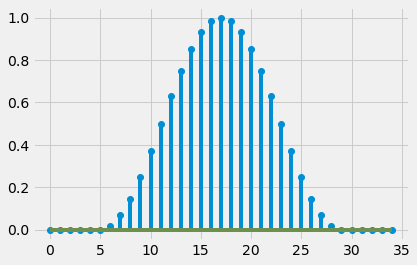

In [11]:
plt.stem(window(25, n0=5, wN=35, wname='hanning'))

In [12]:
def periodogram(x, wname=None, zero_pad=0, normalize=True):
    '''Estimates the Power Spectrum Density with the Periodogram method. Optional arguments are window wname={'rectangular', 'hamming', 'hanning'}; zero_pad=<integer> for DFT; normalize={True, False} for normalizing the output to 1.'''
    
    # Apply window
    if wname is not None:
        w = window(x.shape[0], wname=wname)
        x = x*w
    
    # Apply zero padding
    if zero_pad:
        x = np.hstack((x, np.zeros(zero_pad)))
    
    # Estimate PSD
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape(-1,1)
    e = 2*np.pi/N*k*n
    e = np.exp(-1j*e)
    Xk = (x*e).sum(axis=1)
    Pxx = np.abs(Xk)**2
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean()
    
    return Pxx

In [13]:
np.hstack((np.arange(1,4),np.zeros(4)))

array([1., 2., 3., 0., 0., 0., 0.])

In [14]:
def welch(x, L, D, zero_pad=0, normalize=True, **kwargs):
    '''Estimates the Power Spectrum Density with Welch's method. Periodogram length L, offset by D.'''
    
    # Set shape of periodograms
    N = x.shape[0]
    K = ((N-1) - L)//D
    Pxx = np.empty((K,L+zero_pad))
    
    # Calculate periodograms
    for i in range(K):
        Pxx[i,:] = periodogram(x[i*D:i*D+L], zero_pad=zero_pad, normalize=False, **kwargs)
    
    # Estimate PSD
    Pxx = Pxx.mean(axis=0)
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean()
    
    return Pxx

In [15]:
def multitaper(x, K, zero_pad=0, normalize=True, **kwargs):
    '''Estimates the Power Spectrum Density with the Multi-Taper method, using "poor-man's" tapers.'''
    
    # Calculate the poor-man tapers
    N = x.shape[0]
    n = np.arange(N)
    k = np.arange(K).reshape(-1,1)
    W = np.sqrt(2/(N+1))*np.sin(np.pi*(k+1)*(n+1)/(N+1))
    
    # Set shape of the periodograms
    Pxx = np.empty((K,N+zero_pad))
    
    # Calculate periodograms
    for i in range(K):
        w = W[i,:]
        Pxx[i,:] = periodogram(x*w, zero_pad=zero_pad, normalize=False, **kwargs)
    
    # Estimate PSD
    Pxx = Pxx.mean(axis=0)
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean()
    
    return Pxx

In [16]:
channel = 14
M, N = 1200, 1024
x = X[M:M+N, channel]
xs = Xs[M:M+N, channel]
x.shape, xs.shape

((1024,), (1024,))

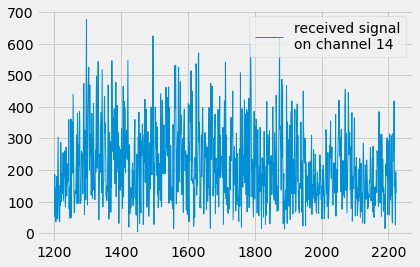

In [17]:
plt.plot(np.arange(M,M+N), np.abs(x), lw=1, label='received signal\non channel 14')
plt.legend()

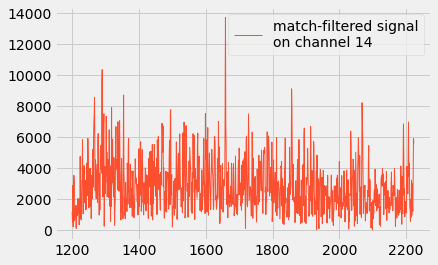

In [18]:
plt.plot(np.arange(M,M+N), np.abs(xs), lw=1, label='match-filtered signal\non channel 14', color=COLORS[1])
plt.legend()

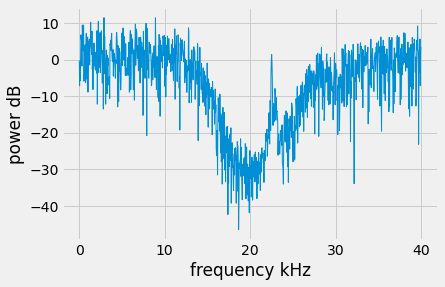

In [19]:
Pxx = periodogram(x, normalize=True)
f = np.linspace(0, fs/1000, Pxx.shape[0])
plt.plot(f, 10*np.log10(Pxx), lw=1)
plt.xlabel('frequency kHz')
plt.ylabel('power dB')
plt.show()

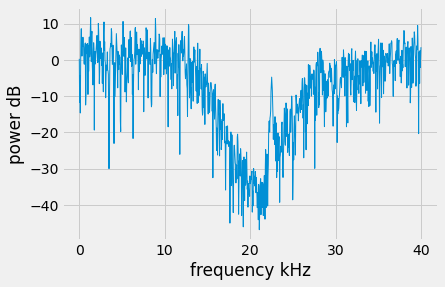

In [20]:
Pxx = periodogram(x, wname='hamming', normalize=True)
f = np.linspace(0, fs/1000, Pxx.shape[0])
plt.plot(f, 10*np.log10(Pxx), lw=1)
plt.xlabel('frequency kHz')
plt.ylabel('power dB')
plt.show()

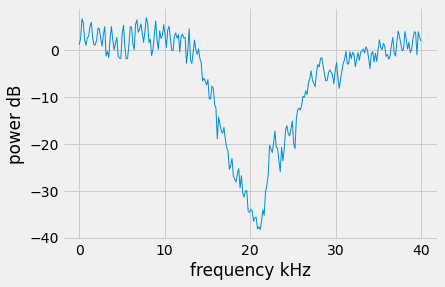

In [21]:
Pxx = welch(x, 256, 256//2, wname='hamming', normalize=True)
f = np.linspace(0, fs/1000, Pxx.shape[0])
plt.plot(f, 10*np.log10(Pxx), lw=1)
plt.xlabel('frequency kHz')
plt.ylabel('power dB')
plt.show()

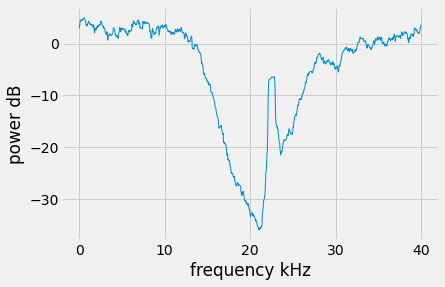

In [29]:
Pxx = multitaper(x, 20)
f = np.linspace(0, fs/1000, Pxx.shape[0])
plt.plot(f, 10*np.log10(Pxx), lw=1)
plt.xlabel('frequency kHz')
plt.ylabel('power dB')
plt.show()